In [1]:
import gdal
import geopandas as gpd
import pandas as pd
import fiona as fi
import matplotlib
import matplotlib.pyplot as plt
from osgeo import ogr
import json
import geojson
import os
from rasterstats import zonal_stats
import rasterio
import numpy as np
import time

### Function to calculate zonal stats

In [2]:
def calcZS(zones, dissField_all, dissField_region, rasterPath, statsList, categorical, calcAllRegions, areaField):
    ## rasterstats manual: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics
    ### calculate zonal stats for each region
    ## dissolve
    zones_diss_region = zones.dissolve(by=dissField_region)
    ## calc zonal stats
    stats_region = zonal_stats(zones_diss_region, rasterPath, categorical = categorical, stats=statsList)
    ## add region as new key/value to list of dictionaries (stats_region output format)
    for counter, region in enumerate(zones_diss_region.index):
        stats_region[counter]["region"] = region
    ## convert to pd df
    stats_region_df = pd.DataFrame(stats_region)
    
    if calcAllRegions == True:
        ### calculate zonal stats across all regions
        ## add field for dissolving
        zones[dissField_all] = 1
        ## dissolve
        zones_diss_all = zones.dissolve(by=dissField_all)
        ## calc zonal stats
        stats_all = zonal_stats(zones_diss_all, rasterPath, categorical = categorical, stats=statsList)
        ## convert to pd df
        stats_all_df = pd.DataFrame(stats_all)
        ## Add "region" column, set value to "All"
        stats_all_df["region"] = "all"
        
        ## concat the two pd dfs
        stats_concat = pd.concat([stats_all_df,stats_region_df], axis = 0, sort=True) 
        
    else:
        stats_concat = stats_region_df
    
        ## Create table of area sums of all selected sites
        sumSelectedSitesByZone = zones.groupby([dissField_region])[areaField].sum().reset_index()

        ## change area column
        sumSelectedSitesByZone = sumSelectedSitesByZone.rename(columns = {"Area": "area_allSelSites_km2", dissField_region: "region"})[["region","area_allSelSites_km2"]]

        ## merge the two df
        stats_concat = stats_concat.merge(sumSelectedSitesByZone, how = "inner", left_on="region", right_on="region")

        ## calculate percentage
        #stats_concat["percent_selSites"] = stats_concat["Area"]/stats_concat['area_allSelSites_km2']
    
    return stats_concat

## Import datasets
### Selected sites

In [3]:
selectedSitesFolder = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\spatialDisaggregation\\selectedsites_cleaned_shp"
allSelecteSitesList = [file for file in os.listdir(selectedSitesFolder) if file.endswith(".shp")]
testLayer = "wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA_OOS_RESOLVEZONE_net_Full_WECC_Cat1_Capped_Basecase_selected.shp"
sp = gpd.read_file(os.path.join(selectedSitesFolder,testLayer))

In [4]:
sp.columns

Index(['Id', 'gridcode', 'Area', 'ORIG_FID', 'Text', 'RESOLVE_ZO',
       'NEAR_FID_n', 'NEAR_DIST_', 'NEAR_FC_ne', 'netREN', 'NEAR_FID_T',
       'NEAR_DIST1', 'NEAR_FC_Tx', 'CF_avg_Cat', 'CF_adj_Cat', 'CF_avg_adj',
       'MW', 'MWh', 'txArea', 'txAreaAdj', 'totArea', 'avgMWhperK', 'zoneID',
       'Full_WECC_', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'geometry'],
      dtype='object')

In [5]:
infrastructureType = "tx_longHaul" ## selSites or tx or tx_longHaul
mainDir = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\"

if infrastructureType == "selSites":
    ## selected sites folder
    allFCfolder = "C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\spatialDisaggregation\\selectedsites_cleaned_shp"
    allFCList = [file for file in os.listdir(allFCfolder) if file.endswith(".shp")]
    suffix = ".shp"
    suffix_solar = ".shp"
    regionField_RESOLVEZONE = "RESOLVE_ZO"
    
if infrastructureType == "tx":
    ## selected sites folder
    spDisaggFolder = os.path.join(mainDir,"spatialDisaggregation\\") #^^
    allFCfolder = os.path.join(spDisaggFolder, "LeastCostPath\\SD_LCP_122018\\SD_LCP_diss")    
    allFCList = [file for file in os.listdir(allFCfolder) if file.endswith(".shp")]
    suffix = "_copy_LCP_erasedBuffLine_diss.shp"
    suffix_solar = "_LCP_erasedBuffLine_diss.shp"
    regionField_RESOLVEZONE = "RESOLVE_ZO"
    
if infrastructureType == "tx_longHaul":
    ## selected sites folder
    #spDisaggFolder = os.path.join(mainDir,"spatialDisaggregation\\") #^^
    allFCfolder = os.path.join(mainDir, "dataCollection\\existingEnergyInfrastructure\\BLMRecentlyApprovedProjects")    
    allFCList = [file for file in os.listdir(allFCfolder) if file.endswith(".shp")]
    suffix = "_copy_LCP_erasedBuffLine_diss.shp"
    suffix_solar = "_LCP_erasedBuffLine_diss.shp"
    regionField_RESOLVEZONE = "RESOLVE_ZO"

### Raster datasets

In [6]:
## housing density layer:
hd_path = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\housingDensity\housingDen2010_merged_raster_proj.tif'
agLand_path = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplc_merged_proj_agLand.tif'
agLand_allCat_path = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplc_merged_proj.tif'
agLand_reclass_path = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\gapLC\gaplc_merged_proj_reclassAg.tif'
rangelands_path = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\RangeGrd\nrirng_RANGE_NUM_proj.tif'

## Loop through selected sites

### Lists

In [8]:
## List scenarios
scenList = ["In-State x Capped Basecase",  "Full WECC x Capped Basecase", "Part WECC x Capped Basecase", \
                        "In-State x Capped highDER", "Full WECC x Capped highDER", "Part WECC x Capped highDER", \
                        "In-State x Capped lowBatt", "Full WECC x Capped lowBatt", "Part WECC x Capped lowBatt",\
                        "In-State BaseUsex Basecase", "Full WECC BaseUsex Basecase", "Part WECC BaseUsex Basecase", \
                         "In-State BaseUsex highDER", "Full WECC BaseUsex highDER", "Part WECC BaseUsex highDER", \
                         "In-State BaseUsex lowBatt",  "Full WECC BaseUsex lowBatt", "Part WECC BaseUsex lowBatt",\
                        "In-State xW2W No Cap Basecase",\
                        "Full WECC xW2W No Cap Basecase",\
                        "Part WECC xW2W No Cap Basecase",\
                         "In-State xW2W No Cap highDER", "Full WECC xW2W No Cap highDER", \
                         "In-State xW2W No Cap lowBatt", "Full WECC xW2W No Cap lowBatt"]

## technologies
techList = ["Geothermal", "Wind", "Solar"]

df_RESOLVEscenarios_total = pd.read_csv(os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\", "RESOLVEoutputs", "Results Summary Workbook_v11_20181214_total.csv"))

### Assumptions for Housing density

In [7]:
## raster file path
rasterPath = hd_path

## stats to calculate
statList = ['count', 'mean', 'min', 'max', 'median']

## whether or not the raster is categorical
categoricalRaster = False

## whether to calculate the "all" in the "region" column
calcAllRegions = True

## column order of final csv
master_df_col_list = ["tech", "envCat", "scenario", "selSites", "region", 'selSitesExist', 'count', 'mean', 'min', 'max', 'median']

## empty dataframe of results
master_df = pd.DataFrame(columns = master_df_col_list)

resultsFileName = os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\",  "areaImpacted_" + infrastructureType + "_SG12_housingDensity_df.csv")

### Assumptions for land cover

In [21]:
## raster file path
rasterPath = agLand_reclass_path #agLand_allCat_path

## stats to calculate
statList = []

## whether or not the raster is categorical
categoricalRaster = True

## whether to calculate the "all" in the "region" column
## don't need to calculate for all regions because this can be done on the df later (by adding across all zones)
calcAllRegions = False

## column order of final csv
master_df_col_list = ["tech", "envCat", "scenario", "selSites", "region", 'selSitesExist', "area_allSelSites_km2", 0, 553, 555, 556, 557]

## empty dataframe of results
master_df = pd.DataFrame(columns = master_df_col_list)

resultsFileName = os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\",  "areaImpacted_" + infrastructureType + "_SG13_gaplc_SG13_df.csv")

### Assumptions for rangelands

In [23]:
## raster file path
rasterPath = rangelands_path #agLand_allCat_path

## stats to calculate
statList = []

## whether or not the raster is categorical
categoricalRaster = True

## whether to calculate the "all" in the "region" column
## don't need to calculate for all regions because this can be done on the df later (by adding across all zones)
calcAllRegions = False

## column order of final csv
master_df_col_list = ["tech", "envCat", "scenario", "selSites", "region", 'selSitesExist', "area_allSelSites_km2", 0, 1,2,3,4,5,11,12,21,22,23,24,31,80,81,82]

## empty dataframe of results
master_df = pd.DataFrame(columns = master_df_col_list)

resultsFileName = os.path.join("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\", "areaImpacted_" + infrastructureType + " _SG17_rangelands_df.csv")

In [25]:
start_time = time.time()
print(start_time)

if infrastructureType == "tx_longHaul":
    print("Working on long haul lines")
    for line in allFCList:
        ## read selected sites (shp) as geodataframe
        sp = gpd.read_file(os.path.join(allFCfolder, line))
        print("Working on " + line)

        if len(sp) > 0:

            ## apply Zonal stats for housing density
            zs_out = calcZS(zones = sp, dissField_all = "dissolve", dissField_region = "STATE", rasterPath = rasterPath, \
                            statsList = statList, categorical = categoricalRaster, calcAllRegions = calcAllRegions, areaField = "Area")

            ## apply Zonal stats for agland
            #agLand_all = calcZS(zones = sp, dissField_all = "gridcode", dissField_region = geography['regionField'], rasterPath = agLand_path, statsList = ['count', 'sum'])

            ## add technology
            zs_out["tech"] = "none"

            ## add scenario name
            zs_out["scenario"] = "none"

            ## add env cat
            zs_out["envCat"] = "none"

            ## add selected sites file name
            zs_out["selSites"] = line

            ## add flag for whether or not there were selected sites for this geography
            zs_out["selSitesExist"] = 1

            ## append area_df to master df
            master_df = pd.concat([master_df, zs_out], axis = 0, sort = True)

            ## reorder fields:
            master_df = master_df[master_df_col_list]

            print("Completed " + line)
            print(str((time.time() - start_time)/(60)) + " minutes")
    
else:
    for tech in techList:
        ## categories
        if tech == "Geothermal":
            catList = {"Cat1" : "geothermal_cat1b", "Cat2" : "geothermal_cat2f",\
                    "Cat3" : "geothermal_cat3", "Cat4": "geothermal_cat4"}
            suffixFinal = suffix

        if tech == "Wind":
            catList = {"Cat1" : "wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2","Cat2" : "wind_0_03_nonEnv_r3_cat2f_singlepart_gt1km2",\
                    "Cat3" : "wind_0_03_nonEnv_r3_cat3c_singlepart_gt1km2", "Cat4": "wind_0_03_nonEnv_r3_cat4_singlepart_gt1km2"}
            suffixFinal = suffix

        if tech == "Solar":
            catList = {"Cat1" : "solarPV_0_0_nonEnv_r1_cat1b_singlepart_gt1km2","Cat2" : "solarPV_0_0_nonEnv_r1_cat2f_singlepart_gt1km2",\
                    "Cat3" : "solarPV_0_0_nonEnv_r1_cat3c_singlepart_gt1km2", "Cat4": "solarPV_0_0_nonEnv_r1_cat4_singlepart_gt1km2"}
            suffixFinal = suffix_solar
        print("===================================")
        print(tech)

        for cat in catList:
            for scen in scenList:
                scen = scen.replace("x", cat)
                if scen in df_RESOLVEscenarios_total.columns: 
                    scenName_field = scen.replace(" ", "_").replace("-", "")                
                    print("")
                    geographyList = []
                    separator = "_" 
                    oos_RESOLVE_filename = separator.join([catList[cat], "PA", "OOS_RESOLVEZONE", "net", scenName_field, "selected"]) + suffixFinal
                    oos_STATE_filename = separator.join([catList[cat], "PA", "state", "net", scenName_field, "selected"]) + suffixFinal
                    instate_filename = separator.join([catList[cat], "PA", "CA_RESOLVEZONE", "net", scenName_field, "selected"]) + suffixFinal

                    if "W2W" in scenName_field and "InState" not in scenName_field:
                        ## append both state and in-state filenames to geoList
                        geographyList.append({"file": oos_STATE_filename, "regionField": "STATE"})
                        geographyList.append({"file": instate_filename, "regionField": regionField_RESOLVEZONE})
                        print("W2W scenario for " + oos_STATE_filename + " and " + instate_filename)

                    if "InState" in scenName_field:
                        ## append only state filename to geoList
                        geographyList.append({"file": instate_filename, "regionField": regionField_RESOLVEZONE})
                        print("InState scenario for " + instate_filename)

                    if any(txt in scenName_field for txt in ["Capped","BaseUseCat1"]) and "InState" not in scenName_field:
                        ## append both OOS RESOLVE ZONES and in-state filenames to geoList
                        geographyList.append({"file": oos_RESOLVE_filename, "regionField": regionField_RESOLVEZONE})
                        geographyList.append({"file": instate_filename, "regionField": regionField_RESOLVEZONE})
                        print("OOS RESOLVE scenario for " + oos_RESOLVE_filename + " and " + instate_filename)

                    ## loop through each element of geoList
                    for geography in geographyList:
                        ## if file is in the geodatabase and it has not already been analyzed
                        ## ex: "geothermal_cat1b_PA_CA_RESOLVEZONE_net_Part_WECC_Cat1_Capped_highDER_selectedcriticalHabitat_SG05" not in list of these in the master_df
                        if geography['file'] in allFCList: #and geography['file']+envData["envDataLabel"] not in (master_df["selSites"]+master_df['envData']).tolist():

                            ## read selected sites (shp) as geodataframe
                            sp = gpd.read_file(os.path.join(allFCfolder, geography['file']))

                            if len(sp) > 0:

                                ## apply Zonal stats for housing density
                                zs_out = calcZS(zones = sp, dissField_all = "dissolve", dissField_region = geography['regionField'], rasterPath = rasterPath, \
                                                statsList = statList, categorical = categoricalRaster, calcAllRegions = calcAllRegions, areaField = "Area")

                                ## apply Zonal stats for agland
                                #agLand_all = calcZS(zones = sp, dissField_all = "gridcode", dissField_region = geography['regionField'], rasterPath = agLand_path, statsList = ['count', 'sum'])

                                ## add technology
                                zs_out["tech"] = tech

                                ## add scenario name
                                zs_out["scenario"] = scenName_field

                                ## add env cat
                                zs_out["envCat"] = cat

                                ## add selected sites file name
                                zs_out["selSites"] = geography['file']

                                ## add flag for whether or not there were selected sites for this geography
                                zs_out["selSitesExist"] = 1

                                ## append area_df to master df
                                master_df = pd.concat([master_df, zs_out], axis = 0, sort = True)

                                ## reorder fields:
                                master_df = master_df[master_df_col_list]

                                print("Completed " + geography["file"])
                                print(str((time.time() - start_time)/(60)) + " minutes")

                            else:
                                ## Create single row dataframe with NA for region and area_km2 to indicate that there are no selected sites for that scenario/geography
                                zs_out = pd.DataFrame(data = {"tech": [tech], "envCat": [cat], "scenario": [scenName_field], \
                                                               "selSites": [geography['file']], "region": ["NA"], "selSitesExist": [0]})

                                ## append area_df to master df
                                master_df = pd.concat([master_df, zs_out], axis = 0)

                                ## reorder fields:
                                master_df = master_df[master_df_col_list]

                                print("***There are no selected sites for empty " + geography["file"])
                        else:
                            print("Not in gdb or already analyzed and in master_df: " + geography['file'])

                    print(str((time.time() - start_time)/(60)) + " minutes")

## reorder fields:
master_df = master_df[master_df_col_list]
master_df.to_csv(path_or_buf = resultsFileName, index = False)
                            
elapsed_time = (time.time() - start_time)/(60)
print("^^^^ Total time for completion: " + str(elapsed_time) + " minutes")

1551758663.4143205
Working on long haul lines
Working on BLM_transmission_line_pref_route_energy_b2h_76mBuff_state.shp


C:\Users\Grace\Anaconda3\lib\site-packages\rasterstats\io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Completed BLM_transmission_line_pref_route_energy_b2h_76mBuff_state.shp
0.02578161160151164 minutes
Working on BLM_transmission_line_pref_route_energy_gateway_south_v2_76mBuff_state.shp
Completed BLM_transmission_line_pref_route_energy_gateway_south_v2_76mBuff_state.shp
0.04541409413019816 minutes
Working on BLM_transmission_line_pref_route_energy_gateway_west_v2_76mBuff_state.shp
Completed BLM_transmission_line_pref_route_energy_gateway_west_v2_76mBuff_state.shp
0.056219605604807536 minutes
Working on BLM_transmission_line_pref_route_energy_southline_state.shp
Completed BLM_transmission_line_pref_route_energy_southline_state.shp
0.07480728228886922 minutes
Working on BLM_transmission_line_pref_route_energy_sunzia_123mBuff_state.shp
Completed BLM_transmission_line_pref_route_energy_sunzia_123mBuff_state.shp
0.11414523919423421 minutes
Working on BLM_transmission_line_pref_route_energy_transwest_express_centerline_76mBuff_state.shp
Completed BLM_transmission_line_pref_route_energy_trans

## ==========================================
## Test time for each zonal stats calculation

### Housing density
#### For all zones (aggregated)

In [35]:
start_time = time.time()
print(start_time)
hd_out_all = calcZS(sp, "gridcode", hd_path,['mean', 'min', 'max', 'median'])
print(str((time.time() - start_time)/(60)) + " minutes")

1548903988.6014905
0.07122885386149089 minutes


In [36]:
stats_all_df = pd.DataFrame(hd_out_all)
## Add "region" column, set value to "All"
stats_all_df["region"] = "all"
stats_all_df

,max,mean,median,min,region
0,347.119276,0.166928,0.0,0.0,all


#### For each region separately

In [21]:
start_time = time.time()
print(start_time)
hd_out = calcZS(sp, "RESOLVE_ZO", hd_path,['count', 'mean', 'min', 'max', 'median'])
print(str((time.time() - start_time)/(60)) + " minutes")

1548902635.734891
0.018000479539235434 minutes


In [22]:
hd_out

[{'min': 0.0,
  'max': 196.608433511,
  'mean': 0.04942187458827628,
  'count': 51641,
  'median': 0.0},
 {'min': 0.0,
  'max': 7.78884348894,
  'mean': 0.20795178302471698,
  'count': 3298,
  'median': 0.177613097959},
 {'min': 0.0,
  'max': 347.119276156,
  'mean': 0.26073150501698805,
  'count': 63248,
  'median': 0.0}]

## Scratch code

In [10]:
sp_diss = sp.dissolve(by="RESOLVE_ZO")

In [11]:
sp_diss["Area_km2"] = sp_diss['geometry'].area/ 10**6
sp_diss

,geometry,Id,gridcode,Area,ORIG_FID,Text,NEAR_FID_n,NEAR_DIST_,netREN,NEAR_FID_T,...,txAreaAdj,totArea,avgMWhperK,zoneID,Shape_Leng,Shape_Le_1,Shape_Area,Part_WECC_,dissolve,Area_km2
RESOLVE_ZO,,,,,,,,,,,,,,,,,,,,,
Central_Valley_North_Los_Banos,(POLYGON Z ((-556210.8385000005 1587506.695800...,539314,1,2.542358,767,None,73,37580.323791,0,3468,...,0.000000,2.542358,79126.120773,CA_RESOLVEZONE_3659,11662.332713,11662.332678,2.542358e+06,True,1,25.395698
Greater_Carrizo,(POLYGON Z ((-557460.8385000005 1301927.7563 0...,662302,1,2.474866,48,None,50,79726.109506,0,5684,...,0.017400,2.492266,85070.594738,CA_RESOLVEZONE_2032,15086.301058,15086.301375,2.474866e+06,True,1,24.615723
Greater_Imperial,(POLYGON Z ((-212220.8635000009 1071100.5885 0...,721773,1,2.458758,251,None,1,75131.227941,0,7134,...,0.045412,2.504170,87119.918049,CA_RESOLVEZONE_2378,10622.400326,10622.400289,2.458758e+06,True,1,98.172339
Kramer_Inyokern,(POLYGON Z ((-317460.8385000005 1263177.7563 0...,656885,1,1.373123,98,None,37,41126.128157,0,8199,...,0.000000,1.373123,91858.262562,CA_RESOLVEZONE_2193,15638.121054,15638.121457,1.373123e+06,True,1,266.761982
Mountain_Pass_El_Dorado,(POLYGON Z ((-137710.8385000005 1381427.7563 0...,638833,1,1.812628,63,None,45,27255.306837,0,7655,...,0.000000,1.812628,90841.837290,CA_RESOLVEZONE_2179,12036.127670,12036.128139,1.812628e+06,True,1,8.946461
Northern_California,"POLYGON Z ((-542435.6272999998 1951177.7563 0,...",401916,1,4.651151,5890,A681970,72,368697.842949,0,1877,...,0.000000,4.651151,81837.115511,CA_RESOLVEZONE_3317,19959.908469,19959.908630,4.651151e+06,True,1,4.651151
Riverside_East_Palm_Springs,(POLYGON Z ((-237339.3004999999 1211177.7562 0...,695231,1,2.099086,628,A325814,11,17630.547452,0,8631,...,0.000000,2.099086,92420.761037,CA_RESOLVEZONE_2347,10513.048536,10513.048408,2.099086e+06,True,1,11.325047
Solano,(POLYGON Z ((-620210.8385000005 1659177.7563 0...,486133,1,2.683879,586,None,73,171364.921841,0,3335,...,0.000000,2.683879,76952.309720,CA_RESOLVEZONE_3357,15580.077504,15580.076985,2.683879e+06,True,1,184.564001
Southern_California_Desert,(POLYGON Z ((-37818.74570000172 1278124.4974 0...,657964,1,2.053328,101,None,38,3293.687531,0,2073,...,0.000000,2.053328,89516.781564,CA_RESOLVEZONE_2293,16415.595087,16415.595091,2.053328e+06,True,1,13.674767


In [ ]:
### Test categorical raster in zonal stats

In [18]:
stats_region_agLand_categories = zonal_stats(sp_diss, agLand_allCat_path, categorical=True, stats = [])
stats_region_agLand_categories[0]

{39: 191,
 40: 2,
 41: 7,
 277: 8,
 278: 5,
 302: 5,
 304: 17547,
 384: 6,
 432: 31,
 472: 4,
 539: 132,
 556: 8034,
 557: 1536,
 558: 25,
 579: 58,
 581: 555,
 582: 103,
 583: 4}

In [14]:
## add region as new key/value to list of dictionaries (stats_region output format)
for counter, region in enumerate(sp_diss.index):
    stats_region_agLand_categories[counter]["region"] = region
## convert to pd df
stats_region_agLand_categories_df = pd.DataFrame(stats_region_agLand_categories)
stats_region_agLand_categories_df

,39,40,41,277,278,302,304,384,432,472,...,457,497,498,546,301,474,562,56,163,580
0,191.0,2.0,7.0,8.0,5.0,5.0,17547.0,6.0,31.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,747.0,NaN,179.0,26.0,5.0,26.0,12193.0,NaN,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,33.0,5892.0,14938.0,NaN,19.0,39810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,183.0,NaN,NaN,NaN,2.0,39015.0,14021.0,NaN,NaN,93051.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,397.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,66.0,NaN,NaN,228.0,NaN,NaN,16003.0,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8019.0,...,NaN,NaN,NaN,NaN,NaN,18.0,423.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,6.0,35.0,NaN,NaN,4605.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
stats_region_agLand_categories_df[['region', 553, 556, 557]]

,region,553,556,557
0,Central_Valley_North_Los_Banos,NaN,8034.0,1536.0
1,Greater_Carrizo,1.0,5270.0,2114.0
2,Greater_Imperial,NaN,1037.0,1785.0
3,Kramer_Inyokern,NaN,7138.0,2435.0
4,Mountain_Pass_El_Dorado,NaN,156.0,260.0
5,Northern_California,NaN,387.0,1208.0
6,Riverside_East_Palm_Springs,NaN,NaN,NaN
7,Solano,289.0,132579.0,42395.0
8,Southern_California_Desert,NaN,387.0,109.0
9,Tehachapi,NaN,149.0,NaN


In [42]:
start_time = time.time()
print(start_time)
agLand_allCat_area = calcZS(zones = sp, dissField_all = "dissolve", dissField_region = "RESOLVE_ZO", rasterPath = agLand_reclass_path, statsList = [], categorical = True, calcAllRegions = False, areaField = "Area")
print(str((time.time() - start_time)/(60)) + " minutes")

1548987377.6395154
0.09953722556432089 minutes


In [44]:
agLand_allCat_area

,0,556,557,region,553,area_allSelSites_km2
0,18483,8034.0,1536.0,Central_Valley_North_Los_Banos,NaN,25.395698
1,18926,5270.0,2114.0,Greater_Carrizo,1.0,24.615723
2,106272,1037.0,1785.0,Greater_Imperial,NaN,98.172338
3,286423,7138.0,2435.0,Kramer_Inyokern,NaN,266.761983
4,9506,156.0,260.0,Mountain_Pass_El_Dorado,NaN,8.946461
5,3541,387.0,1208.0,Northern_California,NaN,4.651151
6,12586,NaN,NaN,Riverside_East_Palm_Springs,NaN,11.325047
7,29820,132579.0,42395.0,Solano,289.0,184.564001
8,14728,387.0,109.0,Southern_California_Desert,NaN,13.674766
9,13700,149.0,NaN,Tehachapi,NaN,12.446209


In [26]:
zs_out = pd.DataFrame(data = {"tech": [tech], "envCat": [cat], "scenario": [scenName_field], \
                                                           "selSites": [geography['file']], "region": ["NA"]})

In [27]:
test = pd.concat([agLand_allCat_area, zs_out], axis = 0, sort=True)

In [28]:
test

,0,39,40,41,42,43,45,56,159,162,...,580,581,582,583,584,region,tech,envCat,scenario,selSites
0,2.0,12557.0,2.0,189.0,5450.0,5.0,194.0,7.0,23.0,329.0,...,51.0,119576.0,53062.0,13237.0,1335.0,all,NaN,NaN,NaN,NaN
0,NaN,191.0,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,555.0,103.0,4.0,NaN,Central_Valley_North_Los_Banos,NaN,NaN,NaN,NaN
1,NaN,747.0,NaN,179.0,38.0,NaN,83.0,NaN,NaN,NaN,...,NaN,3302.0,103.0,113.0,12.0,Greater_Carrizo,NaN,NaN,NaN,NaN
2,2.0,4.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,...,NaN,12406.0,1694.0,1600.0,7.0,Greater_Imperial,NaN,NaN,NaN,NaN
3,NaN,183.0,NaN,NaN,2.0,NaN,81.0,NaN,23.0,321.0,...,NaN,20733.0,21022.0,2253.0,66.0,Kramer_Inyokern,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.0,769.0,15.0,NaN,Mountain_Pass_El_Dorado,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Northern_California,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,589.0,1204.0,52.0,NaN,Riverside_East_Palm_Springs,NaN,NaN,NaN,NaN
7,NaN,66.0,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,7244.0,3468.0,1114.0,358.0,Solano,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,501.0,488.0,26.0,18.0,Southern_California_Desert,NaN,NaN,NaN,NaN


In [33]:
for counter, region in enumerate(sp_diss.index):
    hd_out[counter]["region"] = region
    
hd_out

[{'min': 0.0,
  'max': 196.608433511,
  'mean': 0.04942187458827628,
  'count': 51641,
  'median': 0.0,
  'region': 'New_Mexico_Wind'},
 {'min': 0.0,
  'max': 7.78884348894,
  'mean': 0.20795178302471698,
  'count': 3298,
  'median': 0.177613097959,
  'region': 'Pacific_Northwest_Wind'},
 {'min': 0.0,
  'max': 347.119276156,
  'mean': 0.26073150501698805,
  'count': 63248,
  'median': 0.0,
  'region': 'Wyoming_Wind'}]

In [34]:
pd.DataFrame(hd_out)

,count,max,mean,median,min,region
0,51641,196.608434,0.049422,0.000000,0.0,New_Mexico_Wind
1,3298,7.788843,0.207952,0.177613,0.0,Pacific_Northwest_Wind
2,63248,347.119276,0.260732,0.000000,0.0,Wyoming_Wind


In [40]:
hd_all = calcZS(zones = sp, dissField_all = "gridcode", dissField_region = "RESOLVE_ZO", rasterPath = hd_path, statsList = ['count', 'mean', 'min', 'max', 'median'])

In [41]:
hd_all

,count,max,mean,median,min,region
0,118187,347.119276,0.166928,0.000000,0.0,all
0,51641,196.608434,0.049422,0.000000,0.0,New_Mexico_Wind
1,3298,7.788843,0.207952,0.177613,0.0,Pacific_Northwest_Wind
2,63248,347.119276,0.260732,0.000000,0.0,Wyoming_Wind


In [18]:
envCatGDB = r"C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envData\envCat_merged.gdb"
envImpactDataGDB = r"C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\envImpactAssessment\envImpactData.gdb"
adminBound = r'C:\Users\Grace\Documents\TNC_beyond50\PathTo100\dataCollection\siteSuitabilityInputs_nonEnv.gdb'

weccBounds = gpd.read_file(adminBound,driver='FileGDB', layer='stateBound_baja')

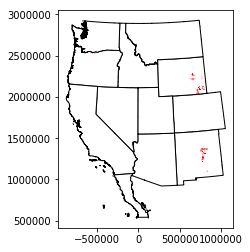

In [19]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
weccBounds.plot(ax=ax, color='white', edgecolor='black')
sp_diss.plot(ax=ax, color='red')
plt.show()